# LayoutLMv3-Invoice Extract: Fine-Tuning for Invoice Understanding

**Project Idea:**  
This project focuses on fine-tuning the **LayoutLMv3** model on the SERIO dataset to improve invoice understanding and entity extraction. The primary goal is to enhance the model's ability to accurately interpret complex invoice layouts, identifying key information such as invoice numbers, dates, total amounts, and line items. By leveraging the LayoutLMv3 model's visual and textual learning capabilities, the project aims to achieve more efficient and accurate processing of invoices for real-world applications in financial management and automated data extraction.

**Objectives:**
- Fine-tune LayoutLMv3 on the SERIO dataset for better invoice understanding.
- Improve the model's ability to recognize key entities such as invoice numbers, dates, total amounts, and line items.
- Apply the model in real-world scenarios to automate invoice data extraction and financial management.

**Conclusion:**  
By enhancing the LayoutLMv3 model's ability to accurately interpret invoices, this project seeks to advance automated solutions for financial document processing, leading to more streamlined workflows in financial and administrative tasks.


## Required Libraries and Imports

The following libraries and modules are essential for data processing, model training, evaluation, and visualization. They include utilities for handling datasets, image transformations, tokenization, and metrics calculation. The LayoutLMv3 model and Trainer from Hugging Face’s `transformers` library are also imported to facilitate token classification tasks on structured documents like invoices.

- **os, glob, shutil**: For file handling and directory management.
- **PIL (Python Imaging Library)**: For image processing and rendering.
- **cv2 (OpenCV)**: For advanced image manipulation and visualization.
- **torch, torchvision**: For building and training deep learning models.
- **transformers**: To use the LayoutLMv3 model, tokenizers, and the Trainer class.
- **sklearn**: To calculate metrics such as accuracy, precision, recall, and F1 score.
- **matplotlib**: For visualizing images and bounding boxes.
- **tqdm**: To display progress bars during training.

In [1]:
import os
import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher
import shutil
from PIL import Image, ImageDraw, ImageFont
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches
from time import perf_counter
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from transformers import LayoutLMv3Tokenizer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification, AutoConfig
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

### let's see one invoice to gain some insights

In [2]:
sroie_folder_path = Path('/kaggle/input/sroie-datasetv2/SROIE2019')
example_file = Path('X51005365187.txt')

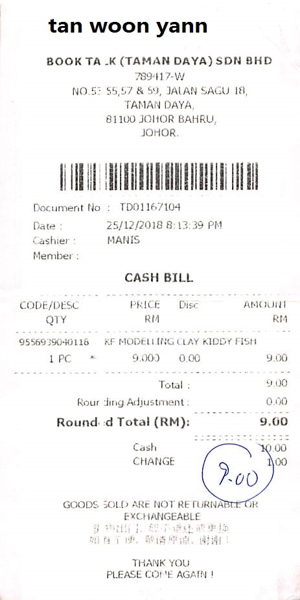

In [3]:
image = Image.open("/kaggle/input/sroie-datasetv2/SROIE2019/train/img/X00016469612.jpg")
image = image.convert("RGB")
new_image = image.resize((300, 600))
new_image

## Data Prepocessing

## Reading Bounding Boxes and Words from Text Files

This function `read_bbox_and_words` reads bounding box coordinates and text from a given file and processes the data into a structured format. The text file is expected to contain comma-separated values where the first eight values represent the bounding box coordinates (in terms of four points: x0, y0, x1, y1, x2, y2, x3, y3) and the remaining values correspond to the associated text. The function splits these values, stores them in a list, and finally converts them into a Pandas DataFrame.

### Steps:
1. **File Reading and Parsing**: The function opens the specified file, processes each line, and extracts bounding box coordinates along with the corresponding text.
2. **Data Storage**: The parsed data is stored in a list and then converted into a DataFrame for easier handling and manipulation.
3. **Bounding Box Conversion**: The bounding box coordinates are explicitly converted into integers for future processing.
4. **Dropping Unnecessary Columns**: Some of the bounding box columns are dropped to simplify the data (e.g., `x1`, `y1`, `x3`, and `y3` are removed).
5. **Preview**: The function returns the processed DataFrame, and we display the first few rows of the file and the DataFrame to verify the result.

The `head()` command is used to show the first five lines from the input file and the first few rows of the resulting DataFrame.


In [4]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0',
                                                         'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'])

  bbox_columns = ['x0', 'y0','x1', 'y1', 'x2', 'y2', 'x3', 'y3'] 
  dataframe[bbox_columns] = dataframe[bbox_columns].astype(np.int16)
    
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== File content ==")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==")
bbox.head(5)

== File content ==


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

== Dataframe ==


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


### Read Entities from JSON: 
This function reads invoice entities from a JSON file and returns them as a Pandas DataFrame.


In [5]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


# Example usage
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}

== Dataframe ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


### Assign Line Label:
This function assigns a label to a line of text based on its similarity to entity names from a DataFrame, returning the matching entity type or "O" for no match.


In [6]:
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_set =  entities.iloc[0, i].replace(",", "").strip().split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: F&P PHARMACY
Assigned label: COMPANY


### Assign Labels:
This function assigns labels to words based on their bounding box dimensions and the presence of entities, ensuring unique assignments for critical fields like TOTAL and DATE while preventing conflicts.


In [7]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

            if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(15)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS
5,X51005365187,111,250,623,275,"SEKSYEN 10, 43300 SERI KEMBANGAN,",ADDRESS
6,X51005365187,186,284,538,308,SELANGOR DARUL EHSAN,ADDRESS
7,X51005365187,251,316,484,339,TEL 03-89599823,O
8,X51005365187,182,351,346,378,GST REG NO,O
9,X51005365187,274,387,461,409,TAX INVOICE,O


In [8]:
bbox_labeled.columns

Index(['filename', 'x0', 'y0', 'x2', 'y2', 'line', 'label'], dtype='object')

### Split Line:
This function splits a line into individual words while maintaining the same bounding box coordinates for each word, as the research indicates that they share the same context.


In [9]:
def split_line(line: pd.Series) -> list:

    if not {'x0', 'x2', 'line'}.issubset(line.index):
        raise ValueError("The line must contain 'x0', 'x2', and 'line' columns.")

    x0 = line['x0']
    x2 = line['x2']
    bbox_width = line['x2'] - line['x0']
    line_str = line['line']

    words = line_str.split()
    new_lines = []

    for index, word in enumerate(words):

        line_copy = line.copy()
        line_copy['x0'] = x0
        line_copy['x2'] = x2
        line_copy['line'] = word
        
        new_lines.append(line_copy.to_list())

    return new_lines



new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,511,143,F&P,COMPANY
1,X51005365187,222,115,511,143,PHARMACY,COMPANY


In [10]:
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)
    new_bbox[['x0', 'y0', 'x2', 'y2']] = new_bbox[['x0', 'y0', 'x2', 'y2']].astype(np.int16)

    del bbox_labeled


    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

In [11]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


100%|██████████| 626/626 [01:07<00:00,  9.34it/s]


Reading dataset:


100%|██████████| 347/347 [00:35<00:00,  9.73it/s]


### train-test split

In [12]:
random.seed(42)
random.shuffle(dataset_test)
dataset_val = dataset_test[174:]
dataset_test = dataset_test[:174]
print(len(dataset_val))
print (len(dataset_test))

173
174


In [14]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from transformers import LayoutLMv3Tokenizer
import torch

class InvoiceDataset(Dataset):
    def __init__(self, invoice_list, tokenizer, image_folder_path):
        self.invoice_list = invoice_list
        self.tokenizer = tokenizer
        self.image_folder_path = image_folder_path
        self.label_map = {
            "S-COMPANY": 0,
            "S-ADDRESS": 1,
            "S-DATE": 2,
            "S-TOTAL": 3,
            "O": 4,
        }
        self.max_length = 512
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224
            transforms.ToTensor(),           
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
        ])

    def __len__(self):
        return len(self.invoice_list)

    def __getitem__(self, idx):
        invoice_data = self.invoice_list[idx]
        word_df = invoice_data[0]  
        image_width = invoice_data[1]  
        image_height = invoice_data[2]  
        image_path = word_df["filename"].iloc[0]  

        words = []
        bboxes = []
        labels = []

        image_path = f"{self.image_folder_path}/{image_path}.jpg"
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None  
        
        image = self.transform(image)

        image = image.unsqueeze(0)

        for _, word_data in word_df.iterrows():
            word = word_data['line'] 
            label = word_data['label']
            bbox = [
                word_data['x0'],
                word_data['y0'],
                word_data['x2'],
                word_data['y2']
            ] 

            normalized_bbox = [
                bbox[0] * 1000 / image_width,
                bbox[1] * 1000 / image_height,
                bbox[2] * 1000 / image_width,
                bbox[3] * 1000 / image_height
            ]

            words.append(word)
            bboxes.append(normalized_bbox)  
            labels.append(label)

        tokens = self.tokenizer(
            words,
            boxes=bboxes,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            is_split_into_words=True,
            return_tensors="pt"
        )

        labels = [self.label_map.get(label, self.label_map["O"]) for label in word_df['label'].tolist()]

        padded_labels = labels + [-100] * (self.max_length - len(labels))  # Use -100 for padding
        labels_tensor = torch.tensor(padded_labels, dtype=torch.long)

        bbox_tensor = tokens['bbox'].squeeze(0)  
        if bbox_tensor.size(0) < self.max_length:
            padding = torch.zeros((self.max_length - bbox_tensor.size(0), 4), dtype=torch.float32)  # Pad with zeros
            bbox_tensor = torch.cat([bbox_tensor, padding], dim=0)

        input_ids_tensor = tokens['input_ids'].squeeze(0).long()
        attention_mask_tensor = tokens['attention_mask'].squeeze(0).long()

        return  {
            'input_ids': input_ids_tensor,
            'attention_mask': attention_mask_tensor,
            'bbox': bbox_tensor.to(torch.long),
            'labels': labels_tensor,
            'pixel_values': image.squeeze(0)
        }

tokenizer = LayoutLMv3Tokenizer.from_pretrained("mp-02/layoutlmv3-large-cord2")

image_folder_path = '/kaggle/input/sroie-datasetv2/SROIE2019/train/img'
dataset = InvoiceDataset(dataset_train, tokenizer=tokenizer, image_folder_path=image_folder_path)
val_set = InvoiceDataset(dataset_val, tokenizer=tokenizer, image_folder_path="/kaggle/input/sroie-datasetv2/SROIE2019/test/img")


tokenizer_config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

### Ensure Tensor Shapes
It is crucial to verify that the shapes of all tensors are correct before proceeding with model training. This includes ensuring that input tensors match the expected dimensions of the model and that target tensors (labels) align with the input tensor shapes. Proper shape management helps prevent runtime errors and ensures the model learns effectively.


In [15]:
print(dataset[0]["input_ids"].shape)
print(dataset[0]["attention_mask"].shape)
print(dataset[0]["bbox"].shape)
print(dataset[0]["labels"].shape)
print(dataset[0]["pixel_values"].shape)

torch.Size([512])
torch.Size([512])
torch.Size([512, 4])
torch.Size([512])
torch.Size([3, 224, 224])


In [16]:
dataset[0]["bbox"]

tensor([[  0,   0,   0,   0],
        [155,  24, 704,  63],
        [155,  24, 704,  63],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]])

In [17]:
import warnings
from transformers import logging as transformers_logging

warnings.filterwarnings("ignore")
transformers_logging.set_verbosity_error()

In [18]:
import wandb
wandb.login(key="43683e6439b3f848199c0e333e5ffdc8c1695604")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training

In this section, we define the training parameters and initialize the `Trainer` for fine-tuning the LayoutLMv3 model on the SERIO dataset. The training arguments include evaluation strategies, logging settings, and learning rate specifications. The model is configured to freeze the first few layers to retain pre-trained weights while allowing the rest to be trainable. The `compute_metrics` function is utilized to evaluate the model's performance during training.

The following code initializes the model and the training process.


In [19]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import LayoutLMv3ForTokenClassification, Trainer, TrainingArguments

def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids 
    
    predictions = np.argmax(logits, axis=-1) 

    mask = labels != -100  
    labels = labels[mask]
    predictions = predictions[mask]

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define class weights
class_weights = torch.tensor([5.0, 5.0, 5.0, 5.0, 1.0])

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "mp-02/layoutlmv3-large-cord2",
    num_labels=5, 
    hidden_dropout_prob=0.2 
)

for idx, param in enumerate(model.parameters()):
    param.requires_grad = idx >= 8

def custom_loss_func(logits, labels):
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    return loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

model.loss_fct = custom_loss_func

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    num_train_epochs=40,
    learning_rate=1e-5,
    report_to='wandb',
    run_name='layoutlmv3-training',  
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1', 
    greater_is_better=True
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=val_set,
    compute_metrics=compute_metrics
)

config.json:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

In [20]:
#trainer.train()

## Best Model Selection

The best model is the one with the highest F1 score on the validation set. This metric provides a balance between precision and recall, making it a suitable choice for evaluating model performance in tasks where class distribution may be imbalanced.


In [21]:
best_model = LayoutLMv3ForTokenClassification.from_pretrained('MohmaedElnamir/fine-tuned-layoutlmv3-sroie')

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [22]:
trainer = Trainer(
    model=best_model,
    args=training_args,
    compute_metrics=compute_metrics
)

training_eval = trainer.evaluate(eval_dataset=dataset)
print("Training Evaluation:", training_eval)

val_eval = trainer.evaluate(eval_dataset=val_set)
print("Validation Evaluation:", val_eval)


wandb: Currently logged in as: mmoa311311 (mmoa311311-egypt-japan-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


{'eval_loss': 0.04341721907258034, 'eval_model_preparation_time': 0.0101, 'eval_accuracy': 0.9847492747617074, 'eval_precision': 0.9831585157474257, 'eval_recall': 0.9847492747617074, 'eval_f1': 0.9822738520112608, 'eval_runtime': 116.4856, 'eval_samples_per_second': 5.374, 'eval_steps_per_second': 2.687}
Training Evaluation: {'eval_loss': 0.04341721907258034, 'eval_model_preparation_time': 0.0101, 'eval_accuracy': 0.9847492747617074, 'eval_precision': 0.9831585157474257, 'eval_recall': 0.9847492747617074, 'eval_f1': 0.9822738520112608, 'eval_runtime': 116.4856, 'eval_samples_per_second': 5.374, 'eval_steps_per_second': 2.687}
{'eval_loss': 0.22810178995132446, 'eval_model_preparation_time': 0.0101, 'eval_accuracy': 0.9609398996621276, 'eval_precision': 0.9527964562549106, 'eval_recall': 0.9609398996621276, 'eval_f1': 0.9565530433881205, 'eval_runtime': 32.0818, 'eval_samples_per_second': 5.392, 'eval_steps_per_second': 2.712}
Validation Evaluation: {'eval_loss': 0.22810178995132446, '

## Evaluating Model performance on the Test Set

In this section, we will evaluate the performance of our trained model on the test set.

In [23]:
test_set = InvoiceDataset(dataset_test, tokenizer=tokenizer, image_folder_path="/kaggle/input/sroie-datasetv2/SROIE2019/test/img")
test_evaluation = trainer.evaluate(eval_dataset= test_set)
print(test_evaluation)

{'eval_loss': 0.22076919674873352, 'eval_model_preparation_time': 0.0101, 'eval_accuracy': 0.962428032559063, 'eval_precision': 0.9535946045374496, 'eval_recall': 0.962428032559063, 'eval_f1': 0.9578960196526791, 'eval_runtime': 33.1849, 'eval_samples_per_second': 5.243, 'eval_steps_per_second': 2.622}
{'eval_loss': 0.22076919674873352, 'eval_model_preparation_time': 0.0101, 'eval_accuracy': 0.962428032559063, 'eval_precision': 0.9535946045374496, 'eval_recall': 0.962428032559063, 'eval_f1': 0.9578960196526791, 'eval_runtime': 33.1849, 'eval_samples_per_second': 5.243, 'eval_steps_per_second': 2.622}


### Great Achievement!
We have achieved an impressive F1 score of **95.8%**! 🎉

## Output Production Phase

In this phase of the pipeline, we aim to produce the output in JSON file format. This is crucial for integrating the model's predictions with other applications or systems that require structured data.

### Steps to Produce JSON Output:

1. **Extract Predictions**: After evaluating the model on the validation/test dataset, extract the relevant predictions (e.g., bounding boxes, labels, company name, date, address, and total).
  
2. **Structure the Data**: Organize the extracted data into a dictionary format. Each entry should correspond to a specific field that we want to include in the JSON output.

3. **Convert to JSON**: Use Python's built-in `json` module to convert the structured data into JSON format.

4. **Save the JSON File**: Write the JSON data to a file for further use or analysis.

This phase is typically referred to as the **Output Generation Phase** in the machine learning pipeline, where we focus on converting model predictions into a consumable format.


### I will use on observation from test set to extract the output as json file a

In [35]:
def generate_labels(sample,best_model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = best_model.to(device)

    observation = {k: v for k, v in sample.items() if k != 'labels'}

    input_ids = observation['input_ids'].unsqueeze(0).to(device)
    attention_mask = observation['attention_mask'].unsqueeze(0).to(device)
    bbox = observation['bbox'].unsqueeze(0).to(device)
    pixel_values = observation['pixel_values'].unsqueeze(0).to(device)



    with torch.no_grad():
        outputs = best_model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        bbox=bbox, 
                        pixel_values=pixel_values)
    return outputs

outputs = generate_labels(test_set[0], best_model)

In [36]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 9.7551, -1.0693, -3.9688, -2.9173, -0.9845],
         [ 9.7453, -2.8938, -2.9135, -2.8906, -1.5974],
         [ 9.8578, -2.6440, -3.0586, -2.9005, -1.4987],
         ...,
         [-1.3434, -0.2802, -1.6220, -2.7532,  6.0141],
         [-1.3434, -0.2802, -1.6220, -2.7532,  6.0141],
         [-1.3434, -0.2802, -1.6220, -2.7532,  6.0141]]], device='cuda:0'), hidden_states=None, attentions=None)

In [37]:
def logits_to_labels(outputs, label_map: dict) -> pd.Series:
    logits = outputs.logits

    predicted_indices = torch.argmax(logits, dim=-1)

    index_to_label = {v: k for k, v in label_map.items()}


    predicted_labels = [index_to_label[idx.item()] for idx in predicted_indices.squeeze()]

    labels_series = pd.Series(predicted_labels)

    return labels_series

label_map = {
    "S-COMPANY": 0,
    "S-ADDRESS": 1,
    "S-DATE": 2,
    "S-TOTAL": 3,
    "O": 4,
}


labels_series = logits_to_labels(outputs, label_map)
print(labels_series)


0      S-COMPANY
1      S-COMPANY
2      S-COMPANY
3              O
4              O
         ...    
507            O
508            O
509            O
510            O
511            O
Length: 512, dtype: object


In [38]:
sample = dataset_test[0][0].drop(["label"], axis= 1)

In [39]:
len(sample)

87

In [40]:
sample_output =pd.concat([sample, labels_series[:len(sample)]], axis= 1)

In [41]:
sample_output.columns = ['filename', 'x0', 'y0', 'x2', 'y2', 'line', 'label']


In [42]:
sample_output

,filename,x0,y0,x2,y2,line,label
0,X51006328345,29,220,616,258,KING'S,S-COMPANY
1,X51006328345,29,220,616,258,CONFECTIONERY,S-COMPANY
2,X51006328345,29,220,616,258,S/B,S-COMPANY
3,X51006328345,29,220,616,258,273500-U,O
4,X51006328345,29,220,616,258,(KJ1),O
...,...,...,...,...,...,...,...
82,X51006328345,35,1247,626,1284,==VISIT,O
83,X51006328345,35,1247,626,1284,US,O
84,X51006328345,35,1247,626,1284,ONLINE,O
85,X51006328345,35,1247,626,1284,AT,O


In [43]:
import pandas as pd
from collections import Counter

def reverse_words_and_vote(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby(['x0', 'y0', 'x2', 'y2'])

    final_labels = []
    
    for (x0, y0, x2, y2), group in grouped:
        reversed_words = ' '.join(reversed(group['line'].tolist()))
        
        label_counts = Counter(group['label'])
        
        most_common_label, count = label_counts.most_common(1)[0]
        
        final_labels.append({
            'filename': group['filename'].iloc[0],
            'x0': x0,
            'y0': y0,
            'x2': x2,
            'y2': y2,
            'line': reversed_words,
            'label': most_common_label,
            'count': count
        })

    final_df = pd.DataFrame(final_labels)

    return final_df

new_sample_output = reverse_words_and_vote(sample_output)

print(new_sample_output.drop("count", axis=1))


        filename   x0    y0   x2    y2  \
0   X51006328345   29   220  616   258   
1   X51006328345   29   258  574   295   
2   X51006328345   29   303   72   330   
3   X51006328345   29   381  390   411   
4   X51006328345   32   343  224   373   
5   X51006328345   32   539  241   571   
6   X51006328345   35   421  375   452   
7   X51006328345   35   500  317   530   
8   X51006328345   35  1247  626  1284   
9   X51006328345   36  1169  517  1200   
10  X51006328345   37  1208  457  1240   
11  X51006328345   38  1130  624  1160   
12  X51006328345   47   618  109   649   
13  X51006328345   50   699  291   728   
14  X51006328345  100  1090  590  1122   
15  X51006328345  119   304  316   332   
16  X51006328345  138   461  534   489   
17  X51006328345  179   622  242   649   
18  X51006328345  182   777  230   812   
19  X51006328345  302   934  350   967   
20  X51006328345  303   817  486   851   
21  X51006328345  303   895  351   925   
22  X51006328345  303  1012  398  

In [44]:
new_sample_output.drop(["count","filename"], axis= 1).to_json(f"/kaggle/working/sample_output.json", orient='records', lines=True)

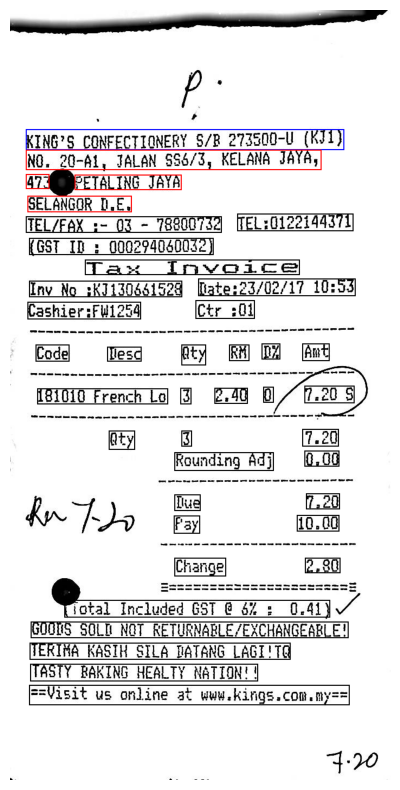

In [45]:
import pandas as pd
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

label_colors = {
    "S-COMPANY": "blue",
    "S-ADDRESS": "red",
    "S-DATE": "green",
    "S-TOTAL": "orange",
    "O": "black"
}

def draw_bounding_boxes(image_path, df):
    try:
        image = Image.open(image_path)
        
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        return None

    draw = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        x0, y0, x2, y2, label = row['x0'], row['y0'], row['x2'], row['y2'], row['label']
        
        color = label_colors.get(label, "black")
        
        draw.rectangle([x0, y0, x2, y2], outline=color, width=2)
        
    return image

image_filename = sample_output['filename'].iloc[0]
image_path = f"/kaggle/input/sroie-datasetv2/SROIE2019/test/img/{image_filename}.jpg"

output_image = draw_bounding_boxes(image_path, new_sample_output)

if output_image is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()
else:
    print("No image to display.")


In [46]:
!pip install huggingface_hub


### Push Our Model to Hugging Face

In this section, we will upload our fine-tuned model to the Hugging Face Model Hub. This allows others to easily access and use our model.

In [47]:
from huggingface_hub import login
login()

In [ ]:
# Import necessary libraries
from transformers import AutoModelForTokenClassification, AutoTokenizer
from huggingface_hub import HfApi, HfFolder

checkpoint_path = '/kaggle/working/results/checkpoint-6573'
model = AutoModelForTokenClassification.from_pretrained(checkpoint_path)



model_name = "MohmaedElnamir/fine-tuned-layoutlmv3-sroie"

model.push_to_hub(model_name)


print(f"Model uploaded to Hugging Face: {model_name}")


In [ ]:
tokenizer_name = "mp-02/layoutlmv3-large-cord2"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model.push_to_hub(model_name)